This notebook presents the final categorical clustering analysis, as referenced in the report. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
import seaborn as sns
import random
import os

# Define functions for analysis

In [2]:
#function for finding the optimal number of k clusters using the elbow method, run time is very high
def optimal_k (kmodes_dict, unique_ages):
    for elem in unique_ages:
        print("Test for ", elem)
        cost = []
        K = range(1,7)
        for num_clusters in list(K):
            kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 7, verbose=0)
            kmode.fit_predict(kmodes_dict[elem])
            cost.append(kmode.cost_)

        plt.plot(K, cost, 'bx-')
        plt.xlabel('No. of clusters')
        plt.ylabel('Cost')
        plt.title('Elbow Method For Optimal k')
        plt.show()

In [3]:
#function for finding the clusters and printing their centroid
#n_init defaults to 1 when Cao is used
#though I will note that previous versions used random initialization with n_init up to 20  
#and the results remained inconsistent

def find_clusters(kmodes_dict, unique_age, n):

    df = kmodes_dict[unique_age]

    kmode = KModes(n_clusters=n, init = 'Cao', n_init = 1, verbose=0)
    clusters = kmode.fit_predict(df)
    print(kmode.cluster_centroids_)
    
    df.insert(0, "Cluster", clusters, True) 
    df['Cluster'] = df['Cluster'] + 1
    
    return df

In [4]:
#function for plotting pie charts, printing the size/breakdowns

def pie_chart_plots(df, n_clusters, thresh, column_names, colors_dict, foldername):
    curr = os.getcwd()
    path = curr + '\\' + foldername + '\\'
    if not os.path.isdir(path):
        os.makedirs(path)
    i = 0
    
    for elem in colors_dict:
        
        fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))

        print("n1 = ", len(df[df['Cluster'] == 1]), ", n2 = ", 
              len(df[df['Cluster'] == 2]), ", n3 = ", len(df[df['Cluster'] == 3]))
        print("p1 = ", round((len(df[df['Cluster'] == 1])/len(df)), 3), ", p2 = ", 
              round((len(df[df['Cluster'] == 2])/len(df)), 3), ", p3 = ", round((len(df[df['Cluster'] == 3])/len(df)), 3))
        
        for k in range(n_clusters):
            k+=1

            cluster = df[df.Cluster == k]
            counts = pd.Series(cluster[column_names[i]]).value_counts()
            counts = counts / sum (counts)
            a = counts[counts > thresh]
            a['other'] = counts[counts <= thresh].sum()

            axes[k-1].pie(a, labels = a.index, colors=[colors_dict[i][v] for v in a.keys()])
            axes[k-1].set_title('Cluster ' + str(k))
        
        fig.suptitle("Plots for Ages " + df['age_bin'][1])
        plt.savefig(fname  = (path + 'Plots for Ages ' + df['age_bin'][1] + '.png'))
        plt.show()
        
        i+=1

In [5]:
#create completely random color assignments for each feature
def create_color_assignments(cat_list, df_kmodes):
    dict_list = []
    
    for elem in cat_list:
        val_list = (df_kmodes[elem].unique()).tolist()
        num_colors = len(val_list)
        colors = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(num_colors)]
        dict_val = dict(zip(val_list, colors))
        dict_val.update({'other':'#990000'})
        dict_list.append(dict_val)
        
    return(dict_list)

# Load and filter data

This notebook demonstrates 100% of the data

In [6]:
#read csv files and store them as pandas dataframes

raw_articles_df = pd.read_csv ('articles.csv')
raw_train_df = pd.read_csv ('transactions_train.csv')
raw_customers_df = pd.read_csv ('customers.csv')

In [14]:
#take sample of transaction data (of 32 million individual transactions) if wanted
#make sure datetime format is used for transaction dates

df_sample = raw_train_df.sample(frac=1, replace=False, random_state=1)
pd.to_datetime(df_sample['t_dat']) 

15937493   2019-08-26
15152782   2019-08-07
3045774    2018-11-25
9939134    2019-05-07
9031640    2019-04-20
              ...    
491263     2018-09-29
12325960   2019-06-22
6762380    2019-02-27
21463275   2020-01-20
12710949   2019-06-26
Name: t_dat, Length: 31788324, dtype: datetime64[ns]

In [15]:
#add categorical data to transactions sample dataframe 

id_type_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.product_type_name))
id_color_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.colour_group_name))
id_patt_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.graphical_appearance_name))
id_age_dict = dict(zip(raw_customers_df.customer_id, raw_customers_df.age))

df_sample['product_type'] = df_sample['article_id'].map(id_type_dict)
df_sample['color'] = df_sample['article_id'].map(id_color_dict)
df_sample['pattern'] = df_sample['article_id'].map(id_patt_dict)
df_sample['age'] = df_sample['customer_id'].map(id_age_dict)

In [16]:
#glance at value counts
df_sample['product_type'].value_counts()

Trousers         4217017
Dress            3238428
Sweater          2783274
T-shirt          2203750
Top              1583408
                  ...   
Eyeglasses            25
Towel                 20
Bumbag                16
Toy                    5
Clothing mist          4
Name: product_type, Length: 130, dtype: int64

In [17]:
#extract the month from the date
#create age bins
#get rid of columns we won't use for now (price, sales channel, article id, date, etc )
#month is created because it was sometimes used in analysis

df_kmodes = df_sample.set_index('customer_id')
df_kmodes['month'] = pd.DatetimeIndex(df_kmodes['t_dat']).month
df_kmodes['age_bin'] = pd.cut(df_kmodes['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

#winter is 12/1/2, spring 3/4/5, etc
df_kmodes = df_kmodes.replace(12,1)
df_kmodes['season'] = pd.cut(df_kmodes['month'], [0, 2, 5, 8, 11], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'])


df_kmodes = df_kmodes.drop(['price', 'sales_channel_id', 'article_id', 't_dat', 'age', 'month'], axis = 1)
df_kmodes.head()

product_type  \
customer_id                                                           
a6219b3851c8347a796fd55713d967dafcceb234d9846ac...  Leggings/Tights   
9313d65212bed757e79f152bfc0b5a2351b2956126bbb98...         Trousers   
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...           Jacket   
66ed0886b5667075037875f6670f479ce39a58611dc7723...            Dress   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...            Socks   

                                                             color  \
customer_id                                                          
a6219b3851c8347a796fd55713d967dafcceb234d9846ac...           Black   
9313d65212bed757e79f152bfc0b5a2351b2956126bbb98...            Blue   
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...  Greenish Khaki   
66ed0886b5667075037875f6670f479ce39a58611dc7723...  Greenish Khaki   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...           Beige   

                                                            pattern age_bin  \
customer_id                                                                   
a6219b3851c8347a796fd55713d967dafcceb234d9846ac...  Colour blocking   20-30   
9313d65212bed757e79f152bfc0b5a2351b2956126bbb98...            Denim   40-50   
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...            Solid   40-50   
66ed0886b5667075037875f6670f479ce39a58611dc7723...            Solid   20-30   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...            Solid   30-40   

                                                    season  
customer_id                                                 
a6219b3851c8347a796fd55713d967dafcceb234d9846ac...  Summer  
9313d65212bed757e79f152bfc0b5a2351b2956126bbb98...  Summer  
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...    Fall  
66ed0886b5667075037875f6670f479ce39a58611dc7723...  Spring  
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...  Spring

In [18]:
#get rid of the most common items (also items that don't change much seasonally/fashionably) as determined by previous analysis
#get rid of things barely purchased

df_kmodes2 = df_kmodes[df_kmodes.color != 'Black' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'White' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'Dark Blue' ]

df_kmodes2 = df_kmodes2[df_kmodes2.product_type != 'Trousers' ]

df_kmodes2 = df_kmodes2[df_kmodes2.groupby('product_type').product_type.transform(len) > 1000]
df_kmodes2 = df_kmodes2.dropna()

df_kmodes2.head()

product_type  \
customer_id                                                       
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...       Jacket   
66ed0886b5667075037875f6670f479ce39a58611dc7723...        Dress   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...        Socks   
546a62fff9f9767a0a7dd59e2ac4cdc048e167ed08c3430...      Sweater   
993643efede1fc62f19d000793fecbef4feb70d6c426571...          Top   

                                                             color  \
customer_id                                                          
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...  Greenish Khaki   
66ed0886b5667075037875f6670f479ce39a58611dc7723...  Greenish Khaki   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...           Beige   
546a62fff9f9767a0a7dd59e2ac4cdc048e167ed08c3430...             Red   
993643efede1fc62f19d000793fecbef4feb70d6c426571...  Greenish Khaki   

                                                             pattern age_bin  \
customer_id                                                                    
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...             Solid   40-50   
66ed0886b5667075037875f6670f479ce39a58611dc7723...             Solid   20-30   
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...             Solid   30-40   
546a62fff9f9767a0a7dd59e2ac4cdc048e167ed08c3430...  All over pattern   30-40   
993643efede1fc62f19d000793fecbef4feb70d6c426571...           Melange    0-20   

                                                    season  
customer_id                                                 
5e1a7591a48786fadc31dc088c1cb4e3d0331817ccfdcb8...    Fall  
66ed0886b5667075037875f6670f479ce39a58611dc7723...  Spring  
62aced2c015c3ee23bb141b2805f257a1fd20964d25d06c...  Spring  
546a62fff9f9767a0a7dd59e2ac4cdc048e167ed08c3430...    Fall  
993643efede1fc62f19d000793fecbef4feb70d6c426571...  Summer

In [33]:
#Create dictionary of dataframes for cluster optimization

#create unique list of ages
unique_ages = df_kmodes2.age_bin.unique()

#create a data frame dictionary to store df
kmodes_dict = {elem : pd.DataFrame() for elem in unique_ages}

for key in kmodes_dict.keys():
    kmodes_dict[key] = df_kmodes2[:][df_kmodes2.age_bin == key]
    
#access with kmodes_dict['key']

In [54]:
#code takes has very long run time
#while some clusters show an elbow at k = 2 or k = 4, many show one at k = 3, as found from prior analysis
#so, for the sake of continuity in the analysis, we will use k = n = 3


#optimal_k (kmodes_dict, unique_ages)

In [34]:
n = 3

df_40 = find_clusters(kmodes_dict, unique_ages[0], n)
df_20 = find_clusters(kmodes_dict, unique_ages[1], n)
df_30 = find_clusters(kmodes_dict, unique_ages[2], n)
df_0 = find_clusters(kmodes_dict, unique_ages[3], n)
df_50 = find_clusters(kmodes_dict, unique_ages[4], n)
df_60 = find_clusters(kmodes_dict, unique_ages[5], n)
df_70 = find_clusters(kmodes_dict, unique_ages[6], n)
df_80 = find_clusters(kmodes_dict, unique_ages[7], n)
df_90 = find_clusters(kmodes_dict, unique_ages[8], n)

[['Sweater' 'Light Beige' 'Solid' '40-50' 'Summer']
 ['Dress' 'Grey' 'All over pattern' '40-50' 'Spring']
 ['Sweater' 'Light Pink' 'Melange' '40-50' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '20-30' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '20-30' 'Spring']
 ['Sweater' 'Grey' 'Melange' '20-30' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '30-40' 'Summer']
 ['Dress' 'Light Pink' 'All over pattern' '30-40' 'Spring']
 ['Sweater' 'Grey' 'Melange' '30-40' 'Fall']]
[['Sweater' 'Red' 'Solid' '0-20' 'Summer']
 ['T-shirt' 'Light Beige' 'All over pattern' '0-20' 'Spring']
 ['Dress' 'Light Pink' 'Solid' '0-20' 'Spring']]
[['Sweater' 'Light Beige' 'Solid' '50-60' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '50-60' 'Spring']
 ['Sweater' 'Grey' 'Melange' '50-60' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '60-70' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '60-70' 'Fall']
 ['Blouse' 'Off White' 'Melange' '60-70' 'Spring']]
[['Sweater' 'Light Beige' 'Solid' '70-80' 'Fall']
 ['Dress' 'Beige'

In [35]:
cat_list = ['product_type', 'pattern', 'color', 'season']

In [36]:
dict_list = create_color_assignments(cat_list = cat_list, df_kmodes = df_kmodes2)

In [37]:
df_list_sort = [df_0, df_20, df_30, df_40, df_50, df_60, df_70, df_80, df_90]

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


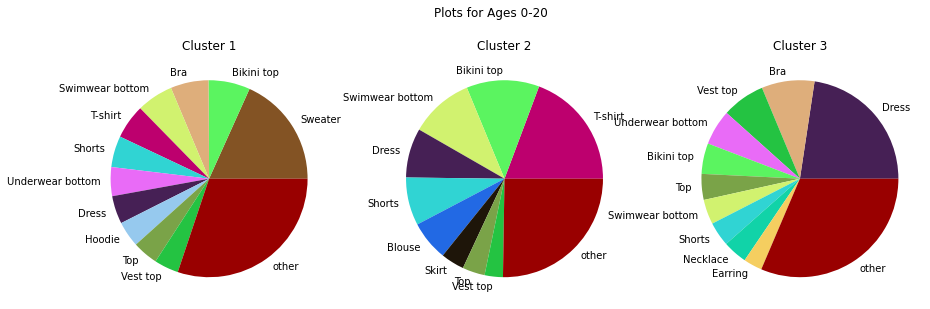

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


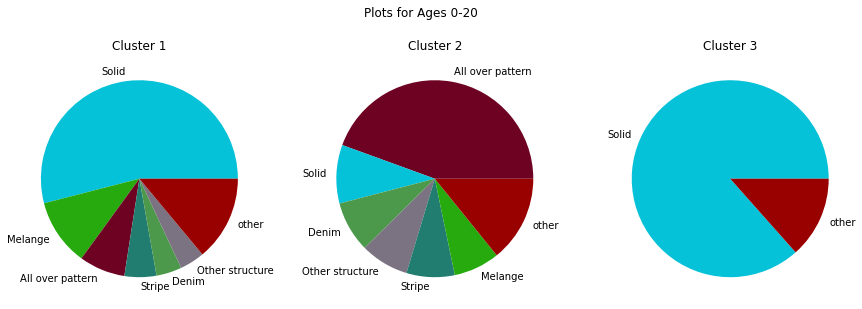

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


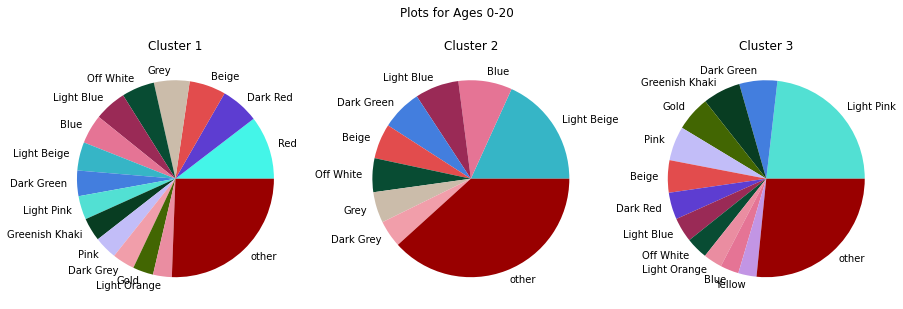

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


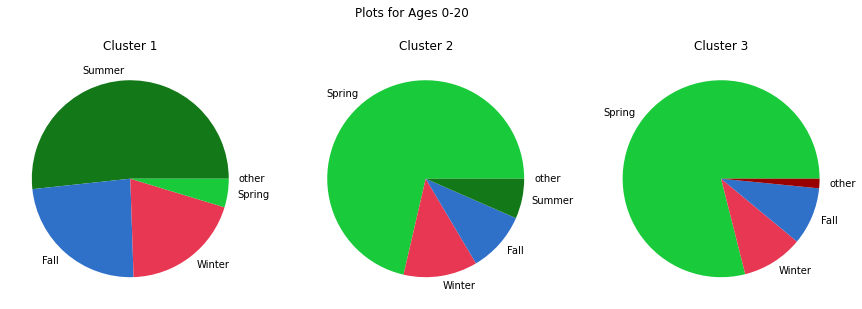

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


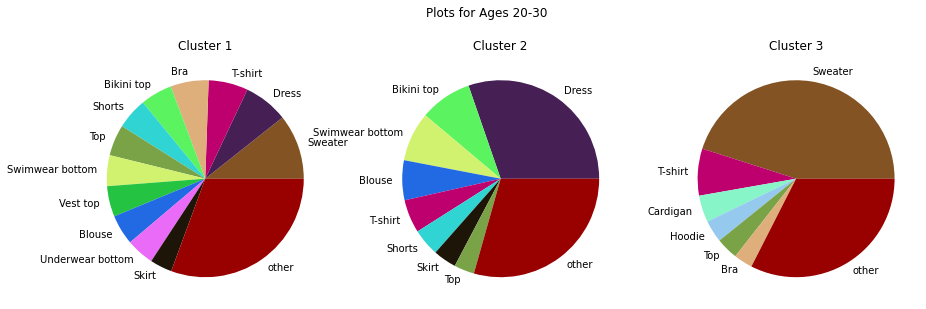

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


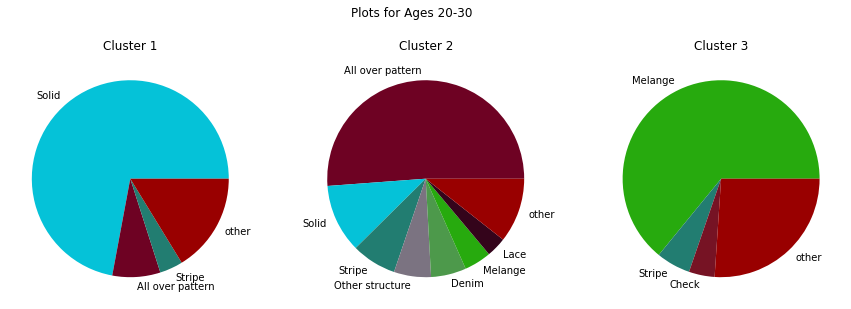

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


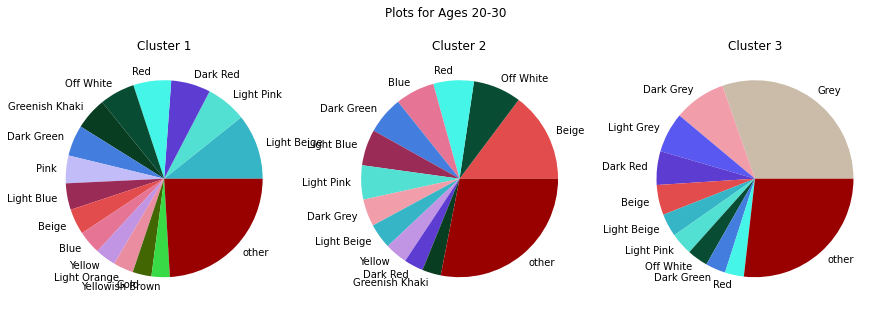

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


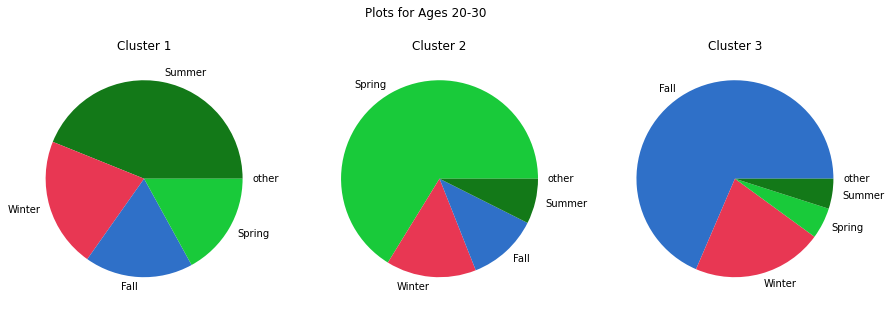

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


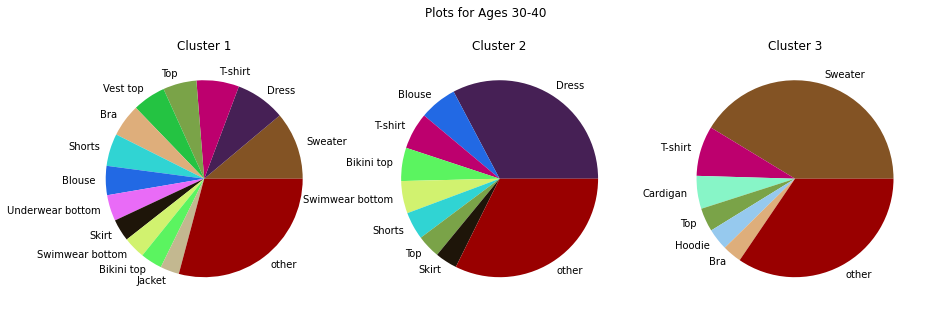

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


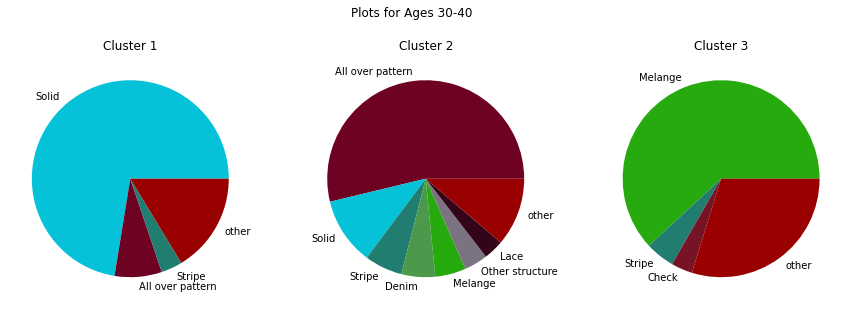

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


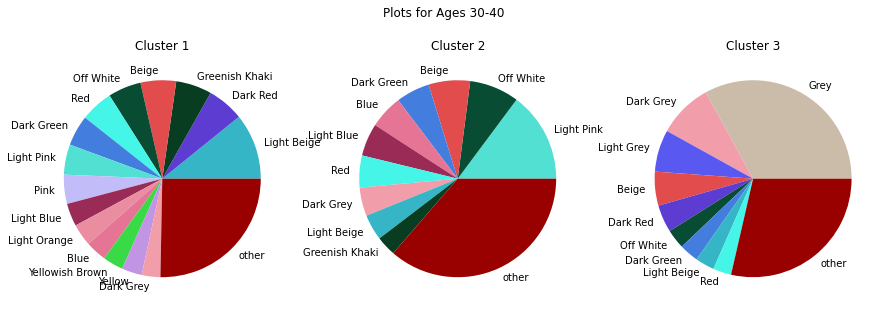

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


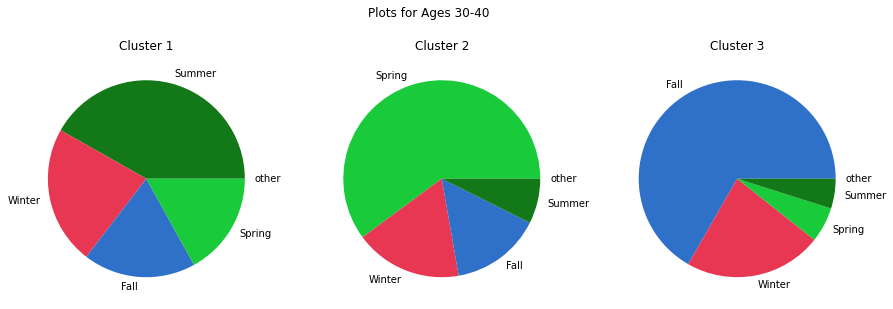

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


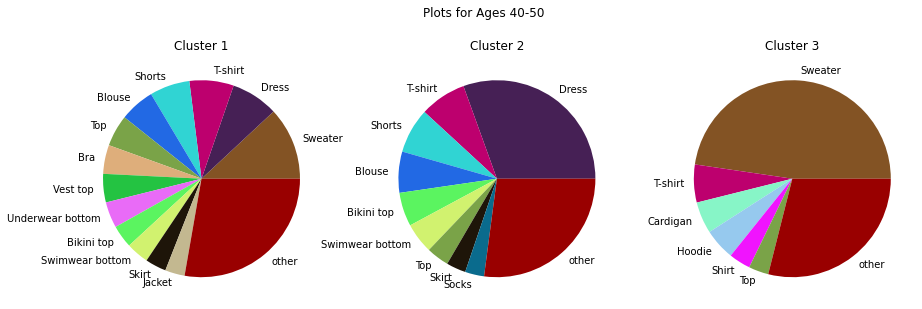

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


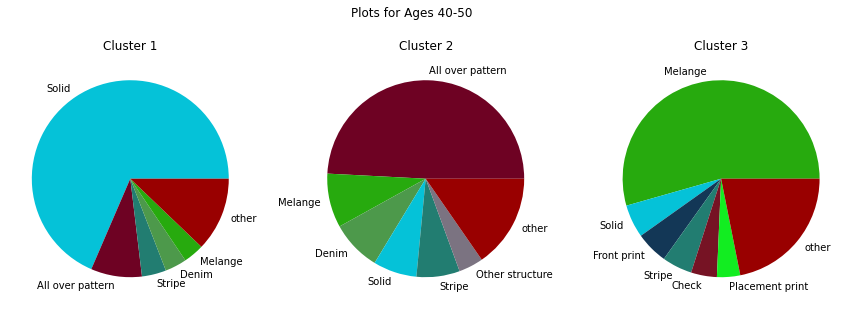

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


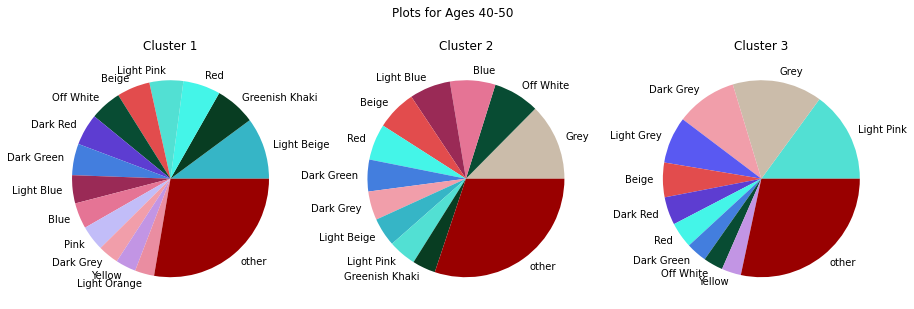

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


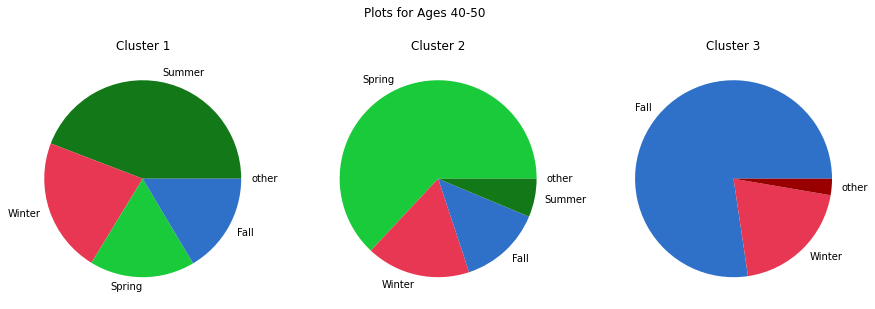

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


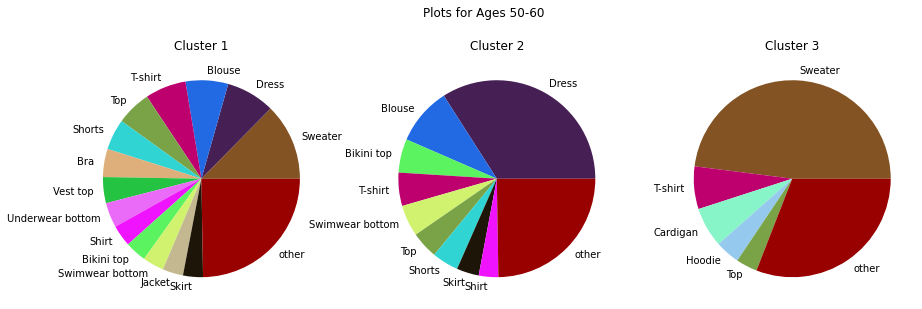

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


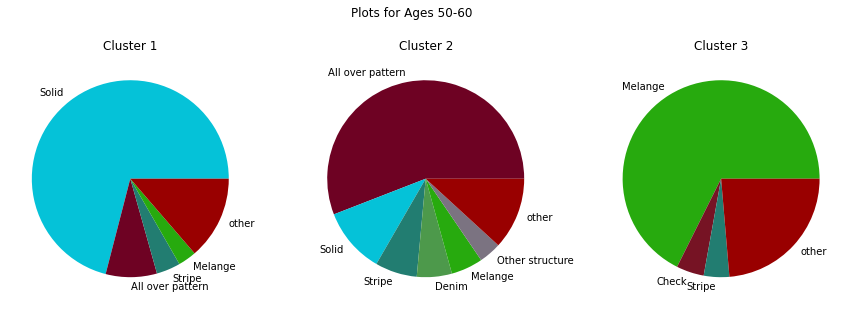

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


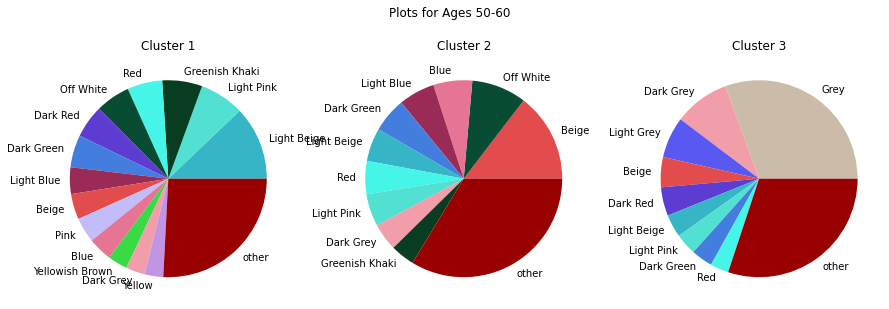

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


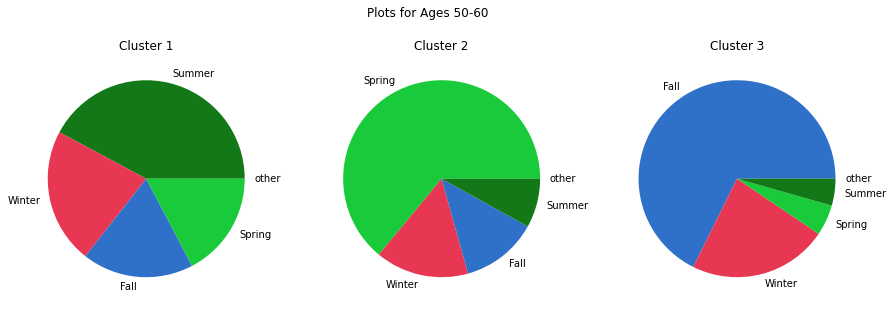

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


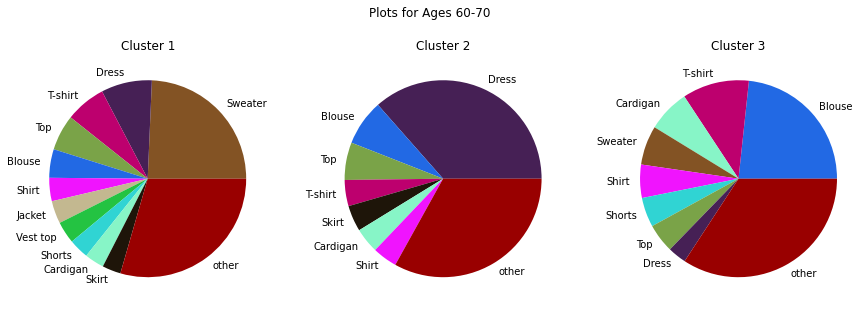

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


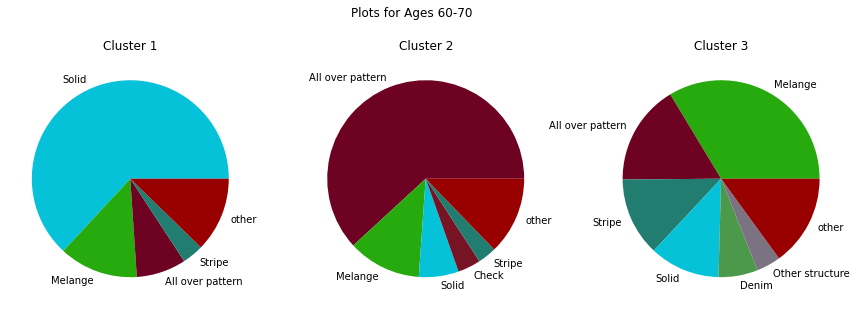

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


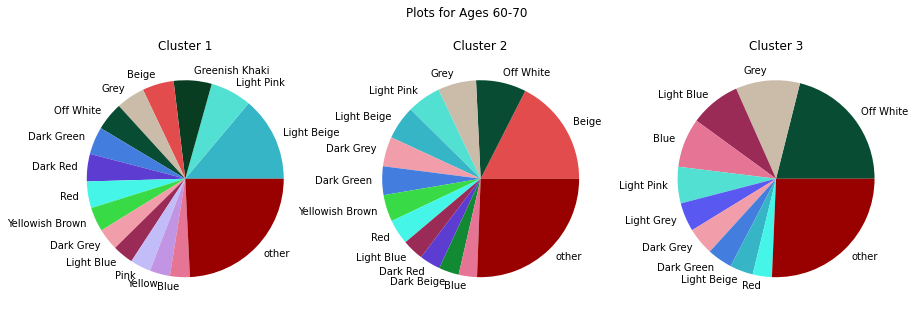

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


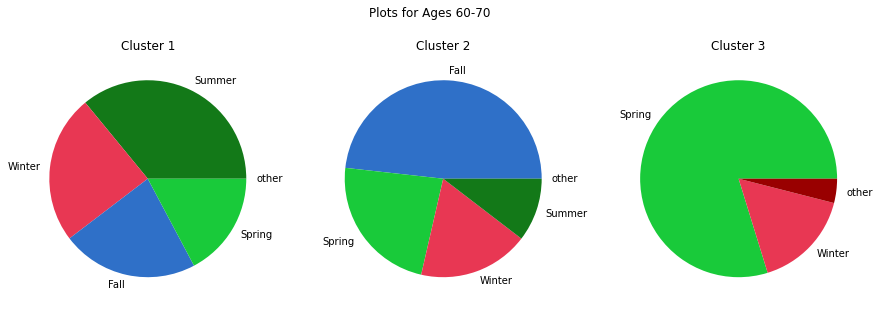

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


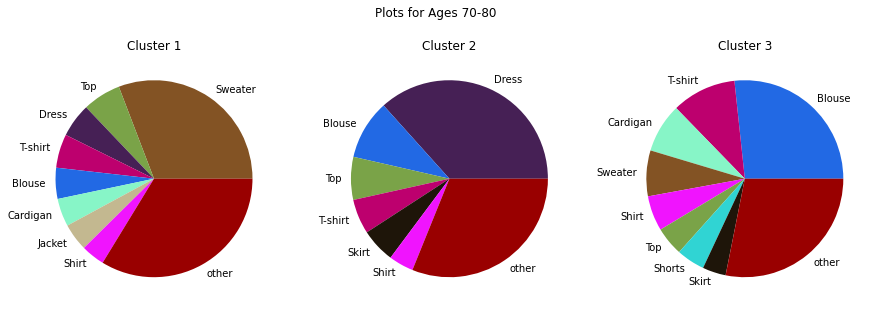

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


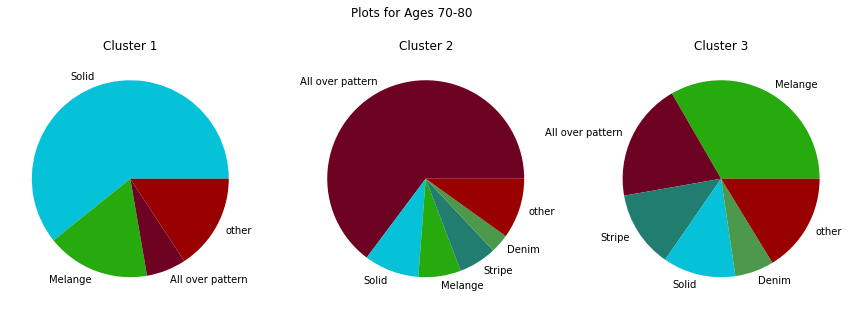

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


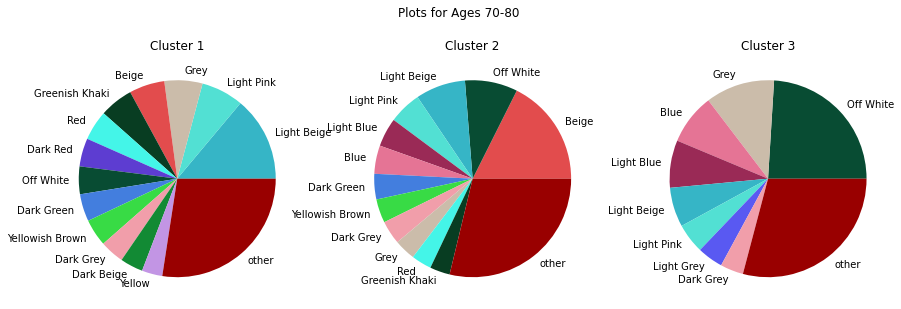

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


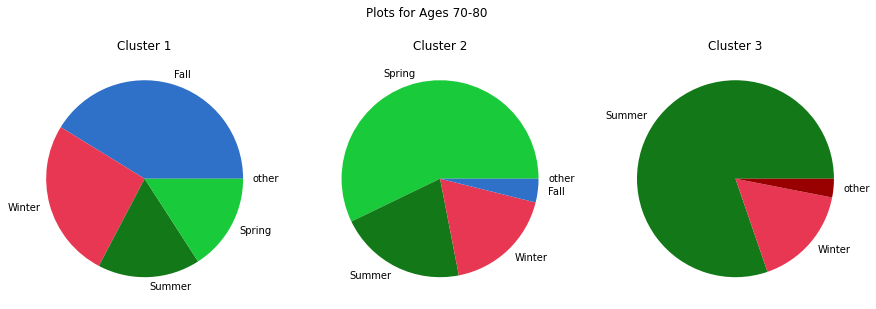

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


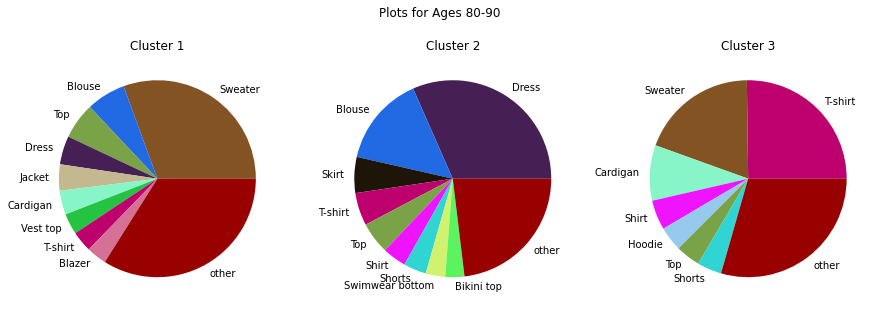

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


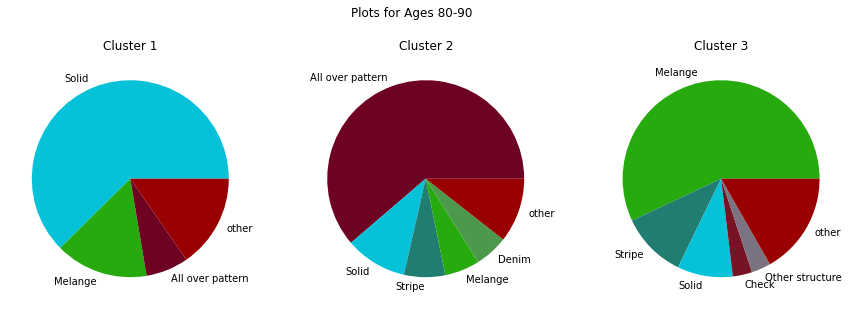

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


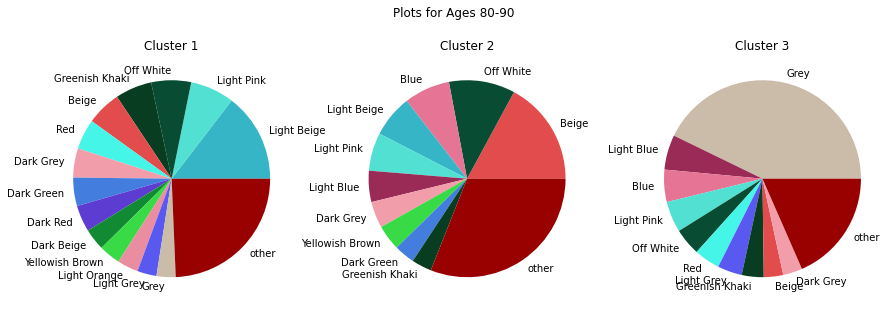

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


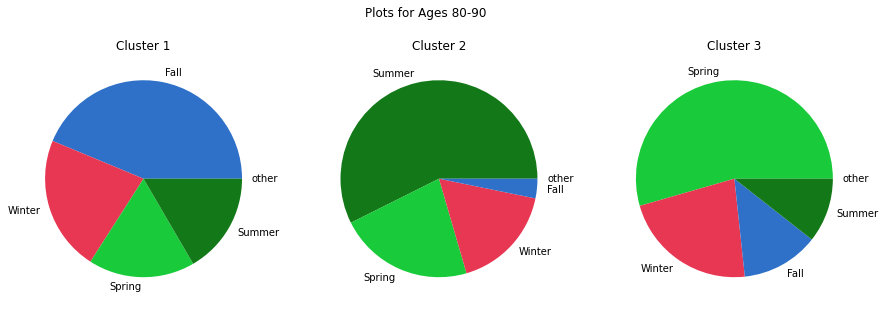

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


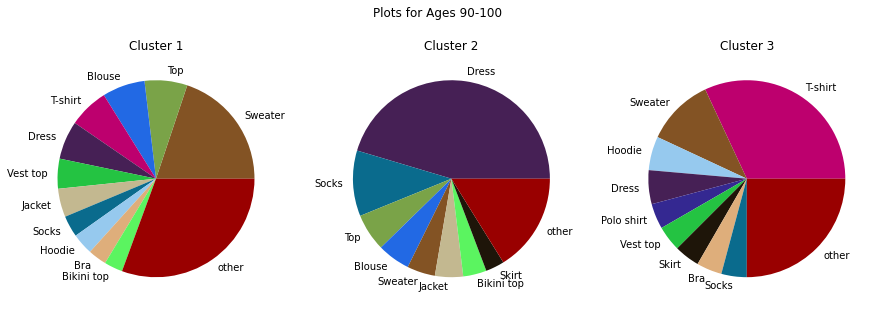

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


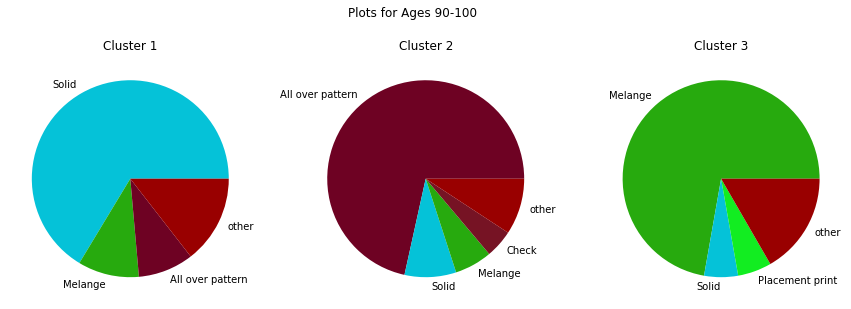

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


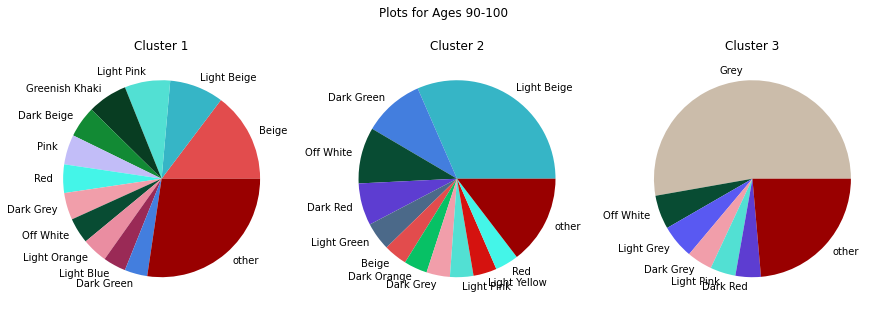

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


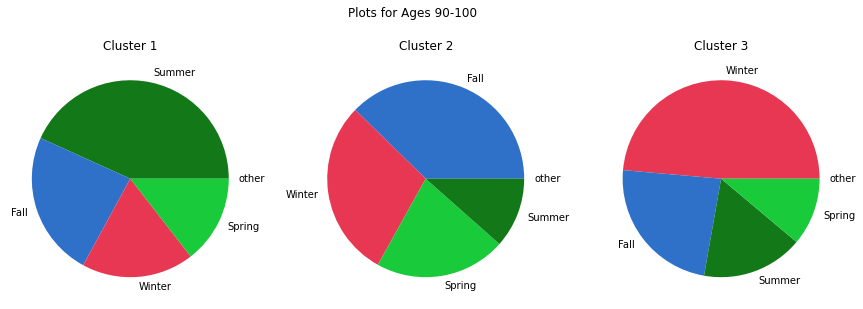

In [39]:
#run for all age groups
for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cat_list, colors_dict=dict_list, foldername = 'Test')

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


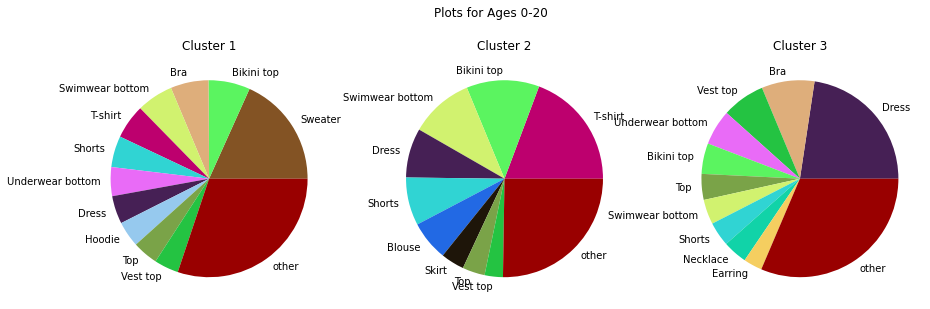

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


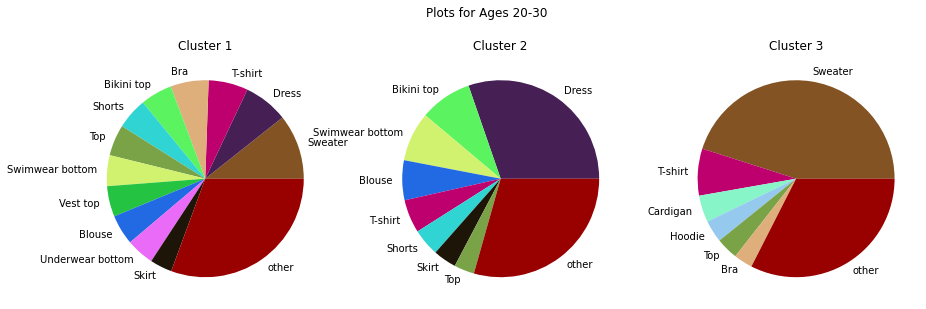

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


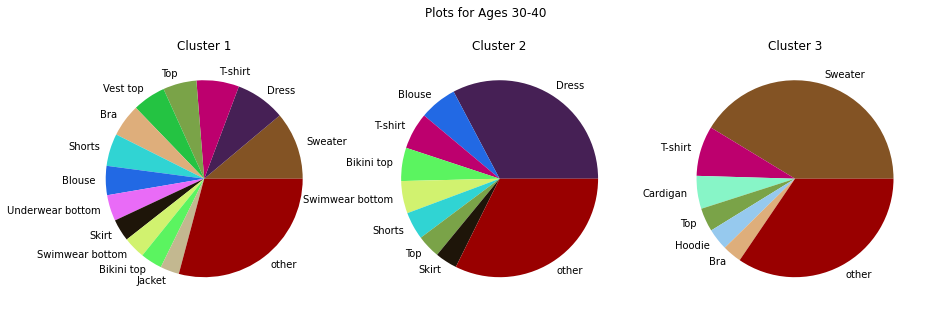

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


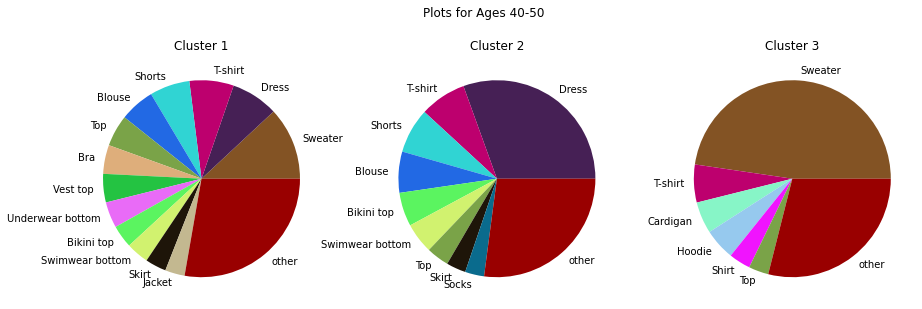

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


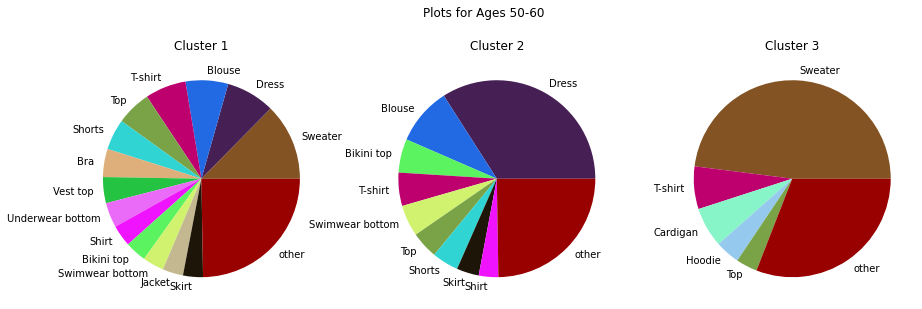

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


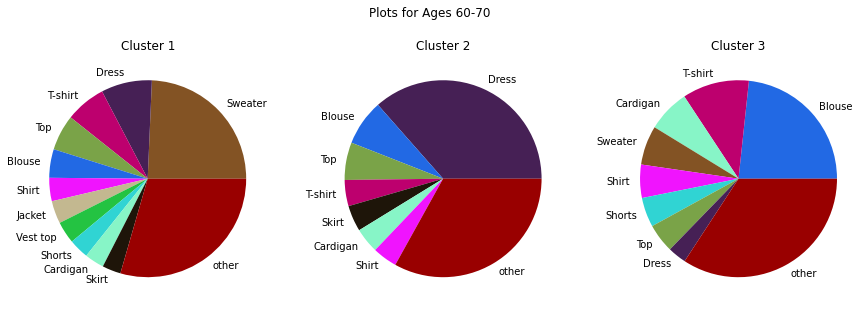

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


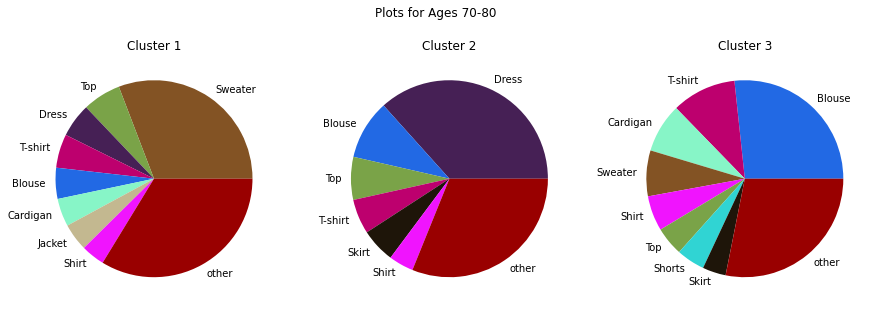

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


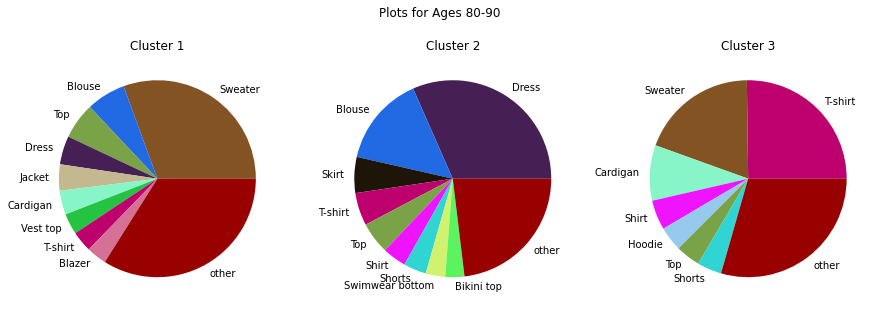

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


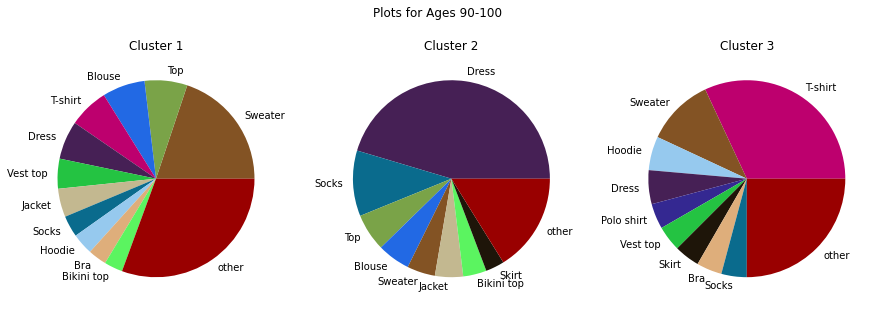

In [40]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#thres is the threshold for what proportion of variable needs to be to be grouped with 'other'
#I will copy and paste this cell with all at the end of the notebook for ease of access

a = 0

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Patterns_Cao')

Fall tendancies: sweaters, cardigan, melange, grey

Spring tendencies: all-over pattern, dresses, swimwear, t-shirts

Summer: high variety, solid 

Winter: none that are strong

# Considering Cluster sizes 

Look at the (almost even) seasonal breakdown in the data...this is not reflected in the clusters

In [41]:
round(df_0['season'].value_counts(normalize=True),2)

Summer    0.36
Spring    0.27
Fall      0.19
Winter    0.17
Name: season, dtype: float64

In [42]:
round(df_20['season'].value_counts(normalize=True),2)

Summer    0.31
Spring    0.26
Fall      0.23
Winter    0.20
Name: season, dtype: float64

In [43]:
round(df_40['season'].value_counts(normalize=True),2)

Summer    0.29
Spring    0.26
Fall      0.24
Winter    0.21
Name: season, dtype: float64

In [44]:
round(df_70['season'].value_counts(normalize=True),2)

Fall      0.28
Spring    0.25
Summer    0.24
Winter    0.23
Name: season, dtype: float64

In [47]:
total_values = []
prop_values = []
for elem in df_list_sort:
    total_values.append(elem['Cluster'].value_counts())
    prop_values.append(elem['Cluster'].value_counts()/len(elem))

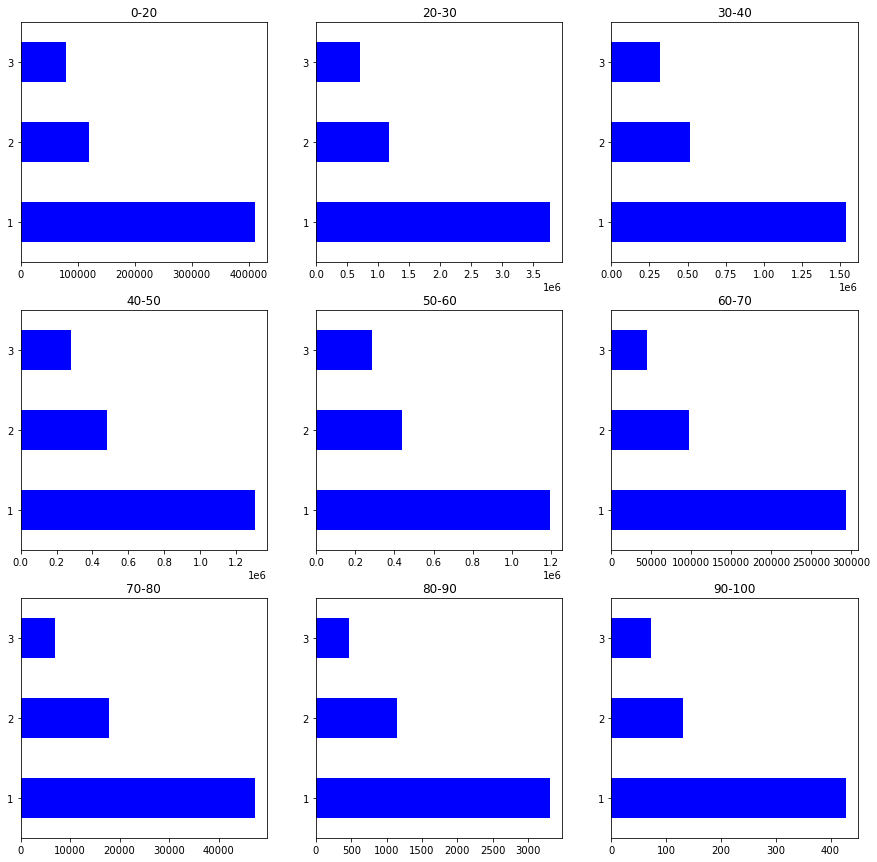

In [48]:
#plot sizes of clusters for each age group

n = 0
plt.figure(figsize=(15, 15))

for elem in df_list_sort: 
    ax = plt.subplot(3, 3, n + 1)
    elem.Cluster.value_counts().sort_index(axis=0).plot(kind = 'barh', ax = ax, color = "blue")
    ax.set_title(elem['age_bin'][1])
    
    n+=1
    
plt.show()

# Misc

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


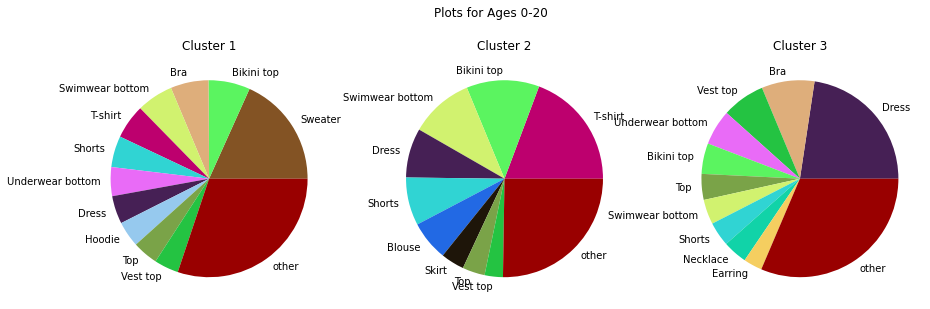

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


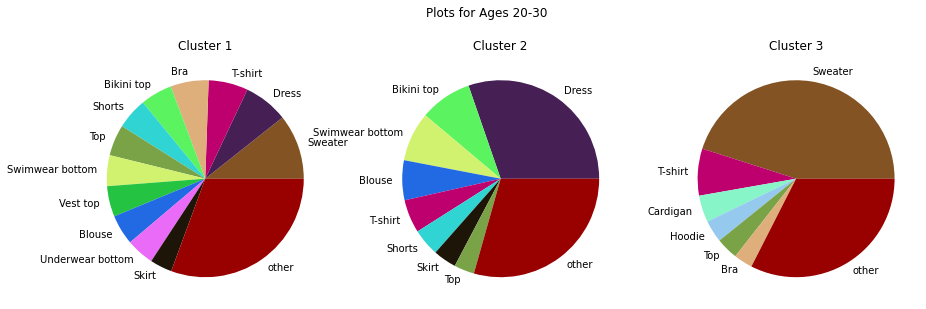

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


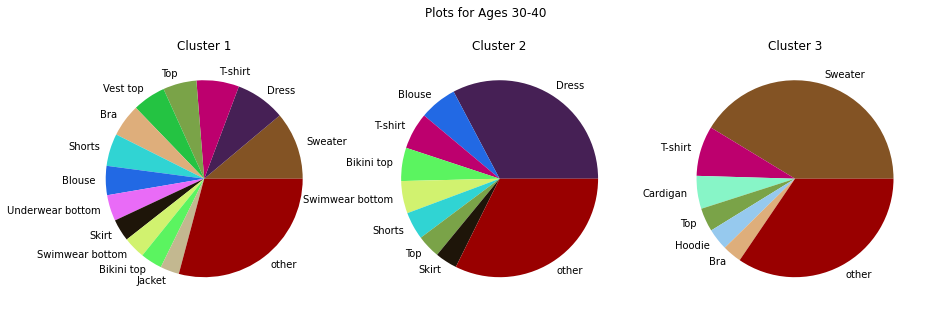

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


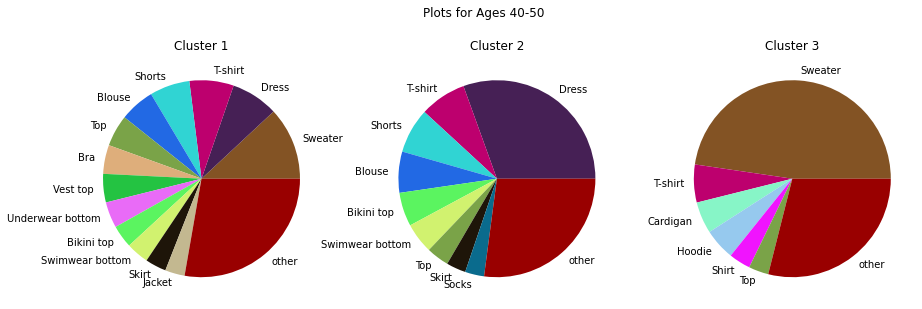

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


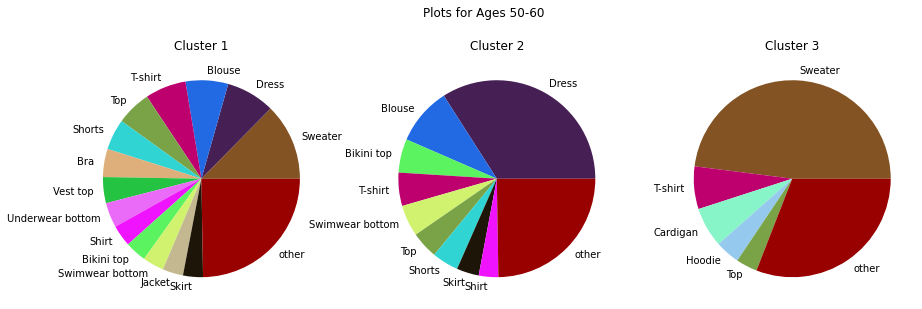

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


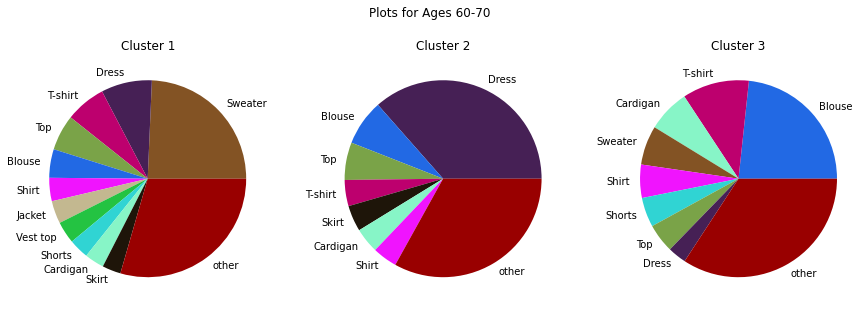

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


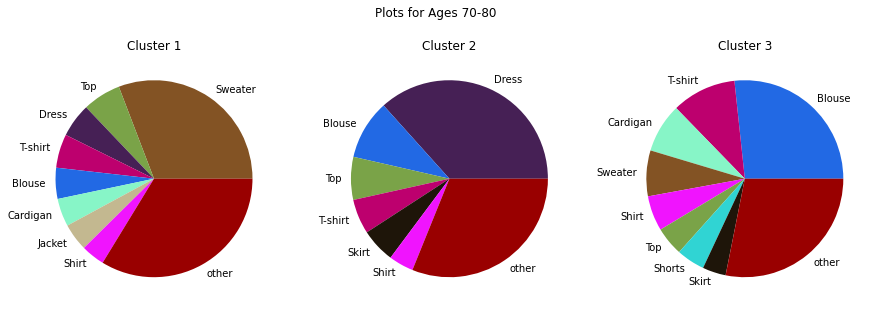

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


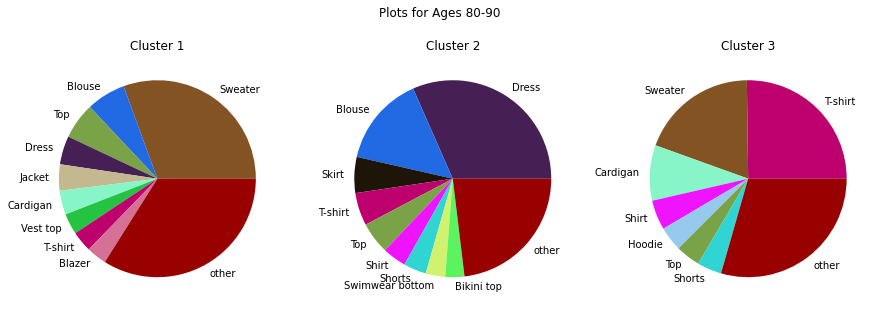

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


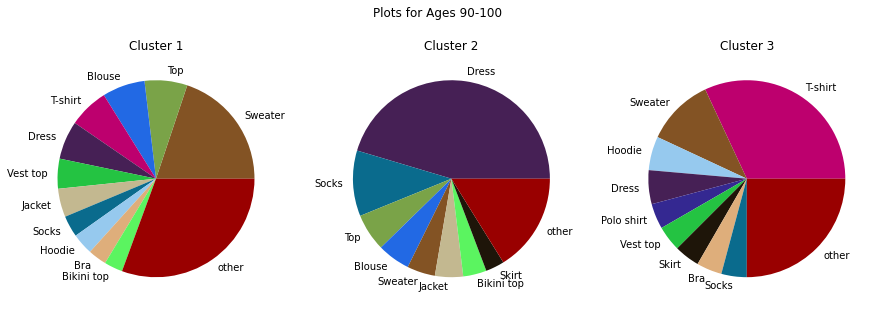

In [50]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 0

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Products_Cao')

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


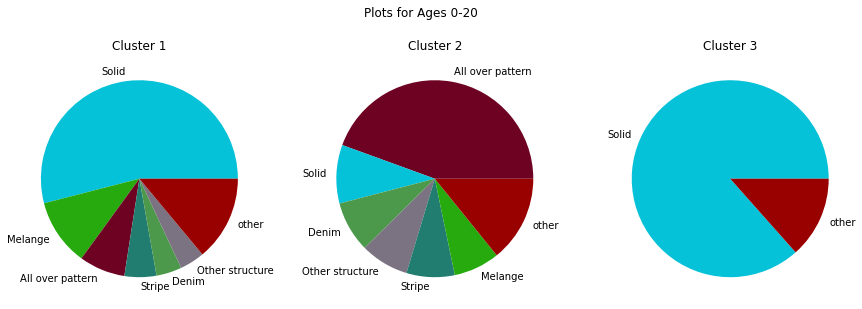

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


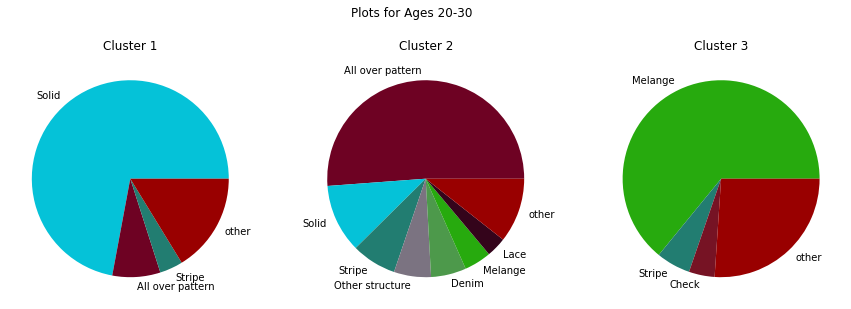

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


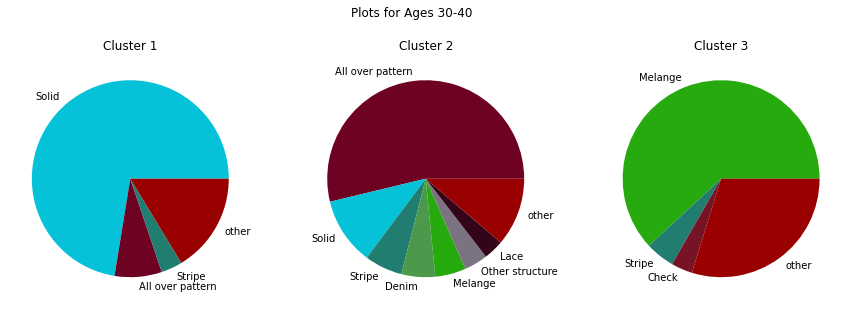

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


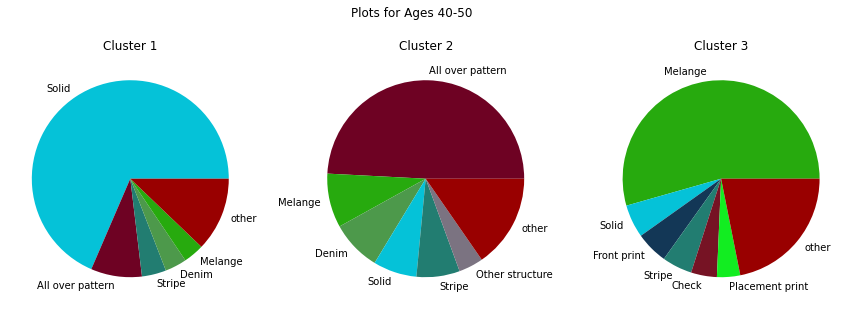

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


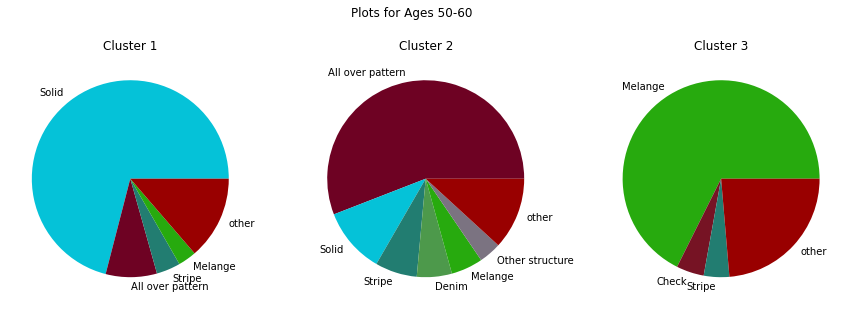

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


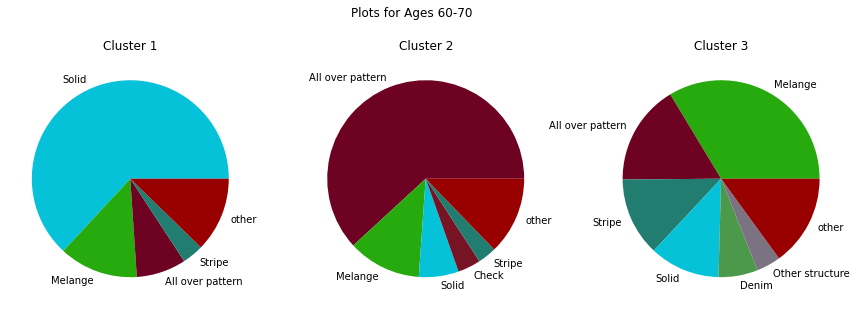

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


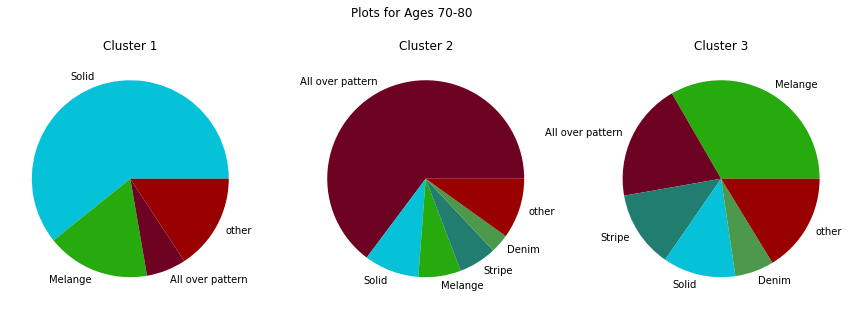

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


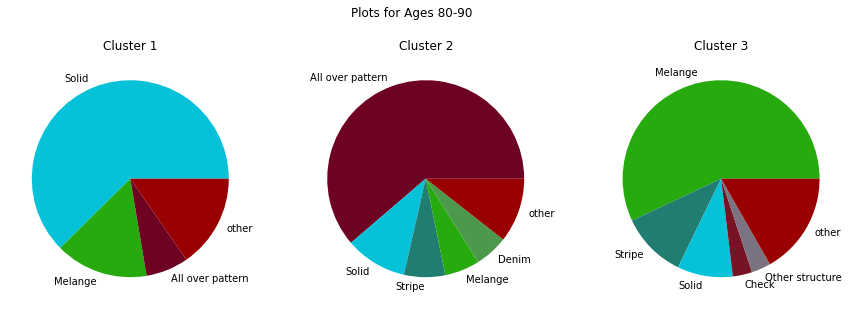

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


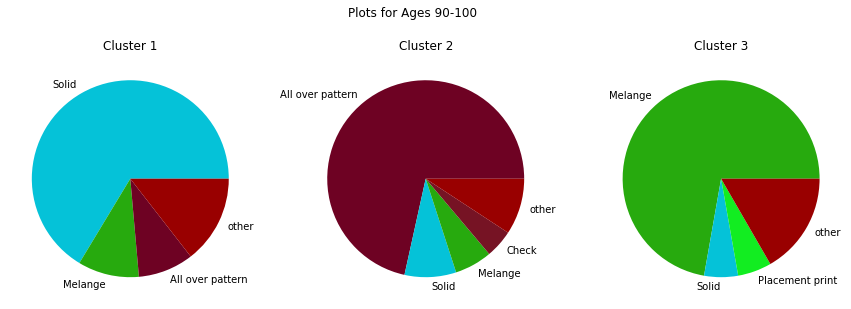

In [51]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 1

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Patterns_Cao]')

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


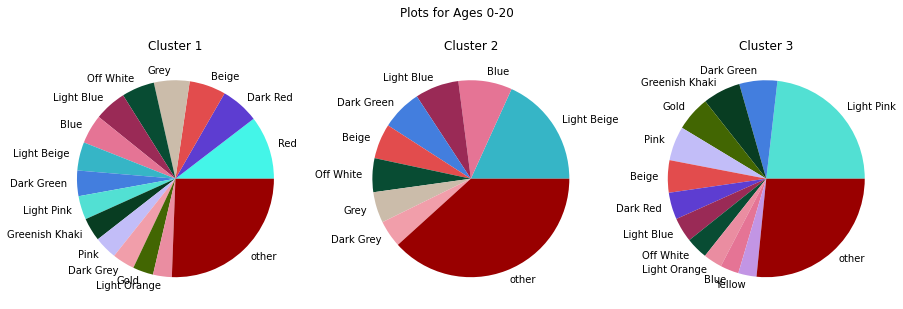

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


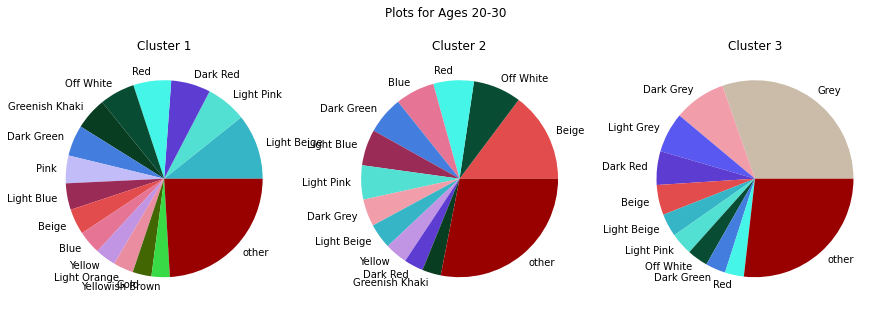

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


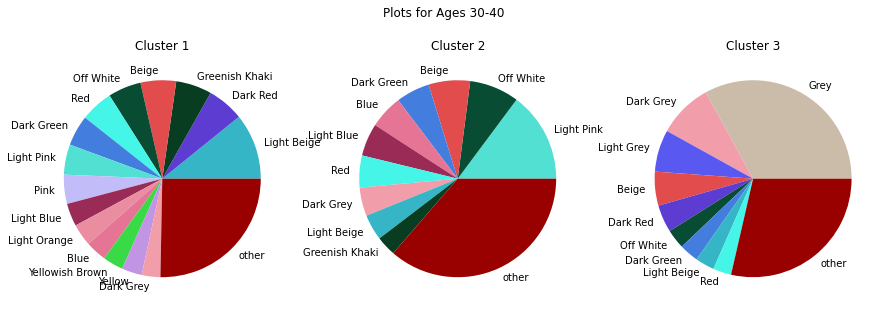

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


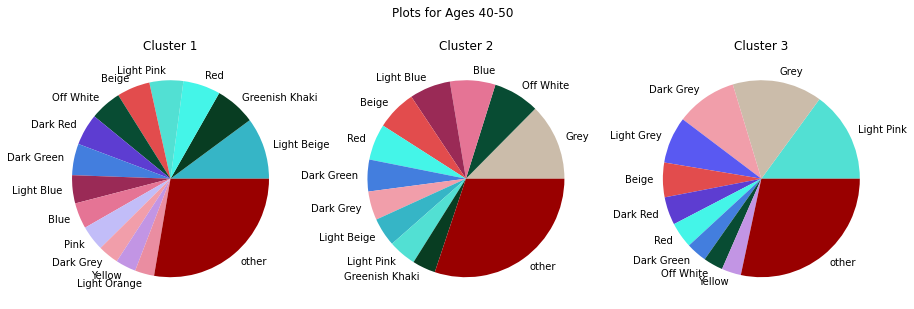

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


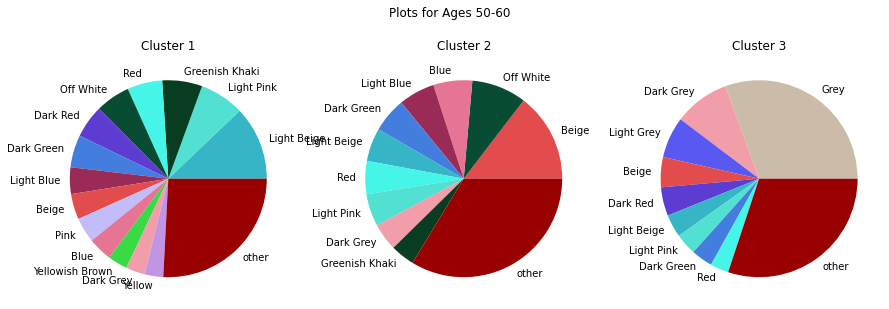

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


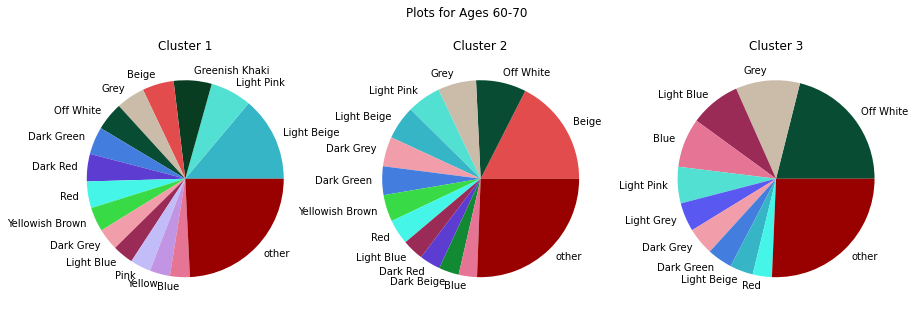

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


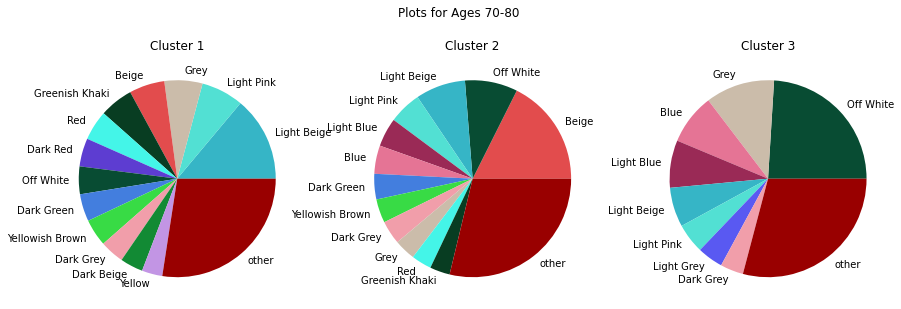

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


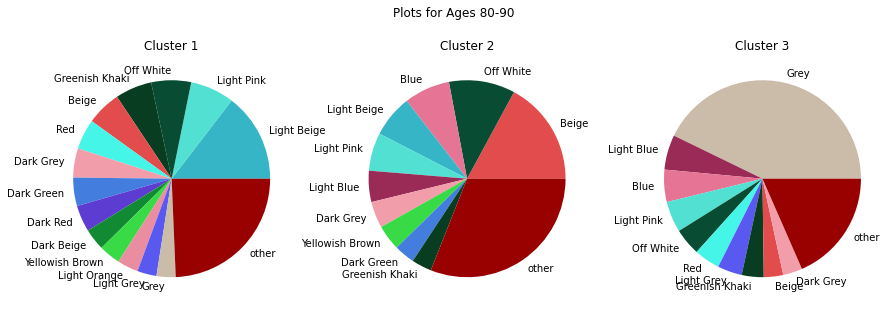

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


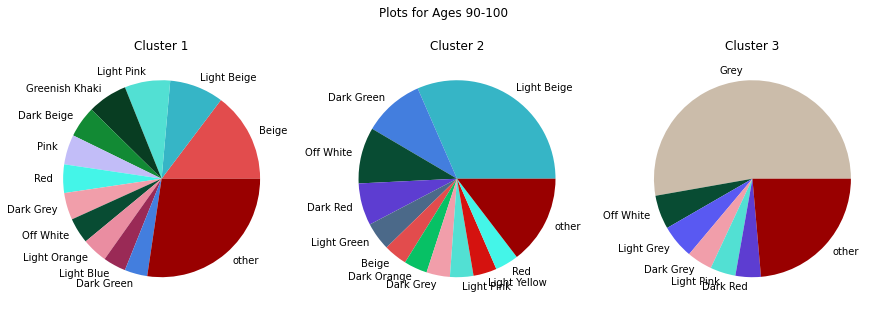

In [52]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 2

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Colors_Cao')

n1 =  411220 , n2 =  120372 , n3 =  78959
p1 =  0.674 , p2 =  0.197 , p3 =  0.129


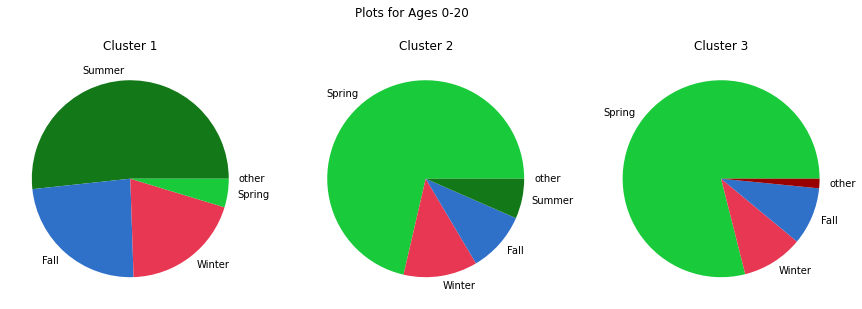

n1 =  3780694 , n2 =  1171521 , n3 =  709971
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


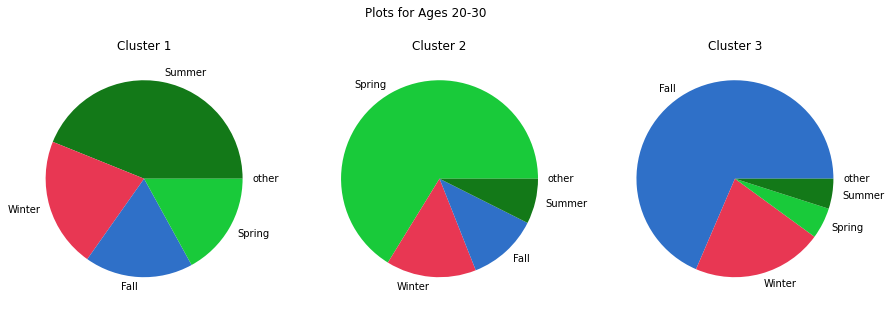

n1 =  1539897 , n2 =  518065 , n3 =  320650
p1 =  0.647 , p2 =  0.218 , p3 =  0.135


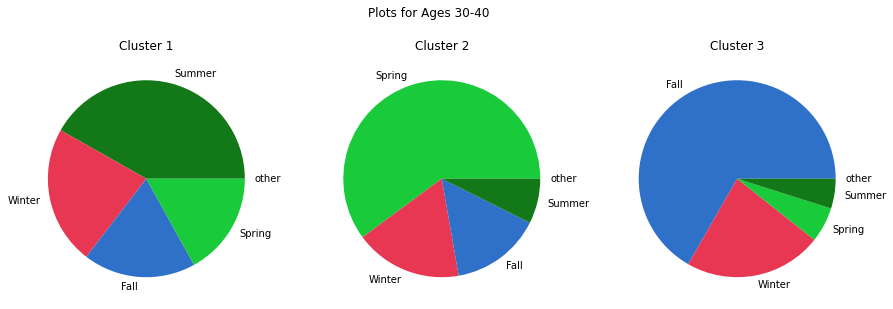

n1 =  1303959 , n2 =  482853 , n3 =  280979
p1 =  0.631 , p2 =  0.234 , p3 =  0.136


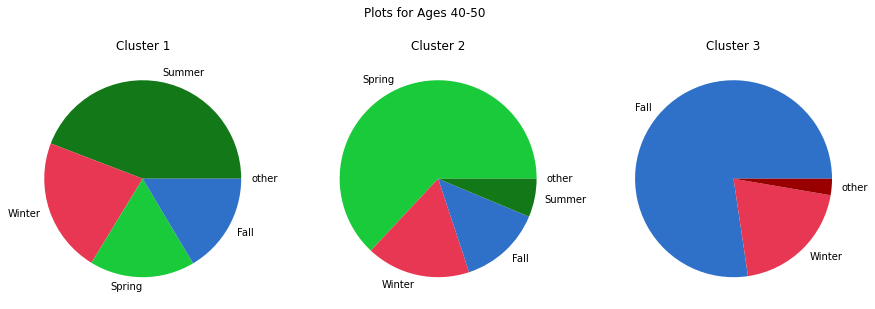

n1 =  1196494 , n2 =  438255 , n3 =  285637
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


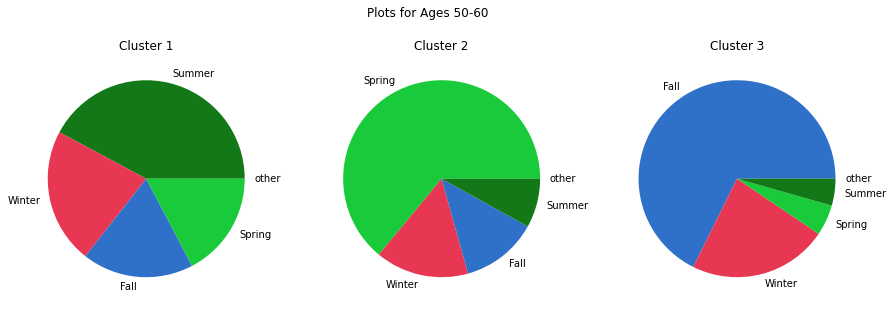

n1 =  293351 , n2 =  97178 , n3 =  44470
p1 =  0.674 , p2 =  0.223 , p3 =  0.102


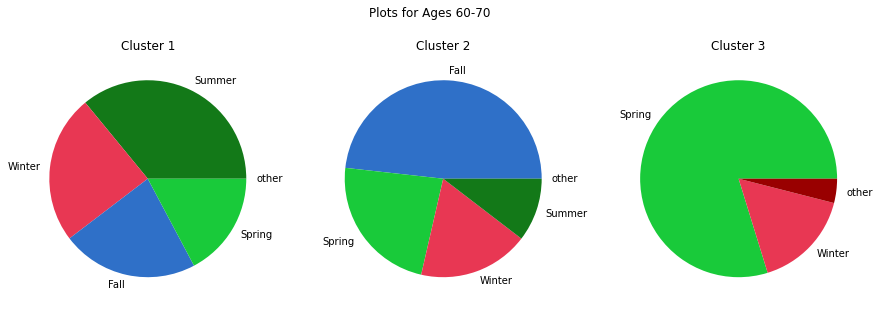

n1 =  47361 , n2 =  17835 , n3 =  6935
p1 =  0.657 , p2 =  0.247 , p3 =  0.096


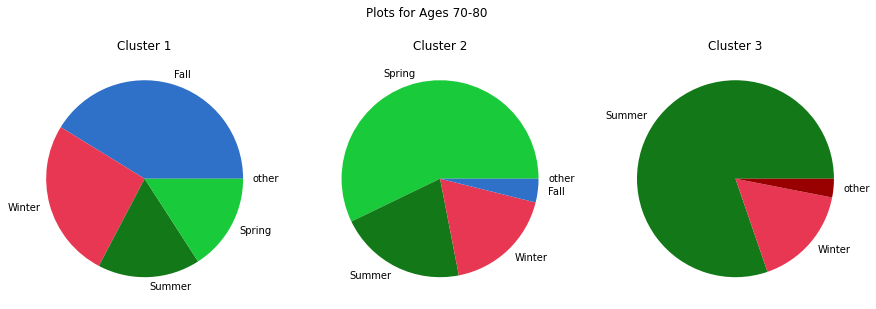

n1 =  3320 , n2 =  1152 , n3 =  472
p1 =  0.672 , p2 =  0.233 , p3 =  0.095


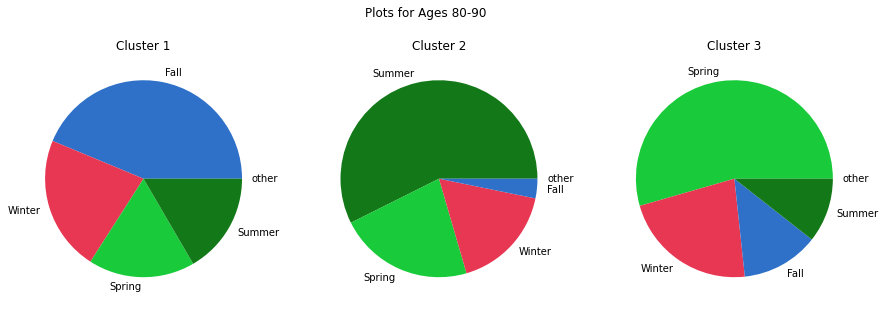

n1 =  428 , n2 =  130 , n3 =  72
p1 =  0.679 , p2 =  0.206 , p3 =  0.114


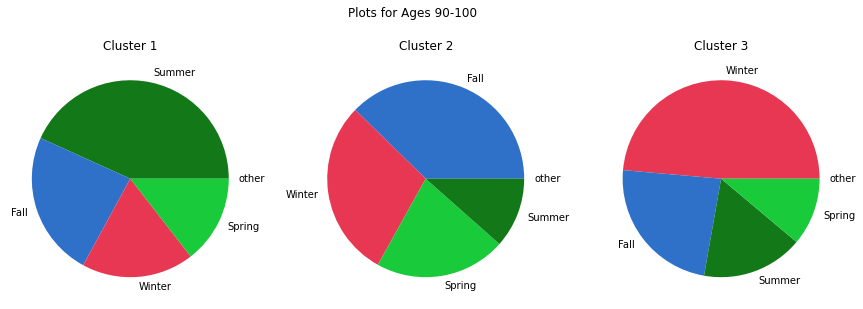

In [53]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 3

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Seasons_Cao]')

Bar charts are too busy for these results